# autoMI with PCFG
This notebooks generates a probabilistic context free grammar (PCFG) and looks at its autoMI. The PCFG model can be thought of as a recursive Markov model: where the Markov model appends states based upon the current state, the PCFG replaces states based upon the current state.

See [Critical Behavior in Physics and Probabilistic Formal Languages. HW Lin, M Tegmark (2017) Entropy](https://doi.org/10.3390/e19070299) for more info.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

## Create PCFG and sample sequences

In [5]:
def gen_balanced_matrix(na=5, ps=[0.7, 0.2, 0.1]):
    """Generates a balanced matrix in which every state can reach every other state
    for hierarchical and Markov models
    """
    for r in range(1000):
        breakme = False
        probs = np.zeros((na, na))
        for p in ps:
            for i in np.arange(na):
                ixloc = np.where(
                    (probs[i, :] == 0) & (np.sum(probs != p, axis=0) == na)
                )[0]
                if len(ixloc) > 0:
                    probs[i, np.random.permutation(ixloc)[0]] = p
                else:
                    # the initialization didn't work
                    breakme = True
        if breakme:
            continue
        probs = probs / np.sum(probs, axis=0)
        return probs
    return "Generation Failed"


def gen_seq_hierarchical(alphabet, probs, depth, n_subsamples):
    """generates a sequence via the Lin Tegmark recursive model
    Arguments:
        alphabet {[type]} -- [alphabet of states]
        probs {[type]} -- [probability matrix for recursive subsampling]
        depth {[type]} -- [how many times to recursively subsample]
        n_subsamples {[type]} -- [the number of new elements to recursively replace old elements with]

    Returns:
        sequence [type] -- [sequence of elements]
    """
    sequence = np.random.choice(
        alphabet, p=np.sum(probs, axis=1) / np.sum(probs), size=1
    )
    if type(depth) == list:
        depth = np.random.choice(depth)
    depth_list = range(depth)
    for i in depth_list:
        q = np.random.choice(n_subsamples)
        sequence = subsample_sequence(sequence, probs, q, alphabet)
    return sequence


def subsample_sequence(sequence, probs, q, alphabet):
    """subsamples a sequence given a probability matrix

    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements

    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    return [
        item
        for sublist in [
            np.random.choice(alphabet, p=probs[:, i], size=q) for i in sequence
        ]
        for item in sublist
    ]

In [6]:
# how many branches to sample in hierarchical
n_subsamples = [2]
# how many subsamples to perform
depth = 20
# alphabet size
a_n = 2
alphabet = np.arange(a_n)
# how many sequences to use
nseq = 1
print('seq len ',(np.mean(n_subsamples)**depth))

seq len  1048576.0


In [7]:
# generate probbility matrix 
probs = gen_balanced_matrix(na=a_n, ps=[.9, .1])

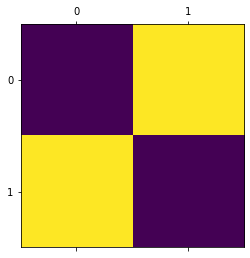

In [9]:
plt.matshow(probs)

In [11]:
sequences = gen_seq_hierarchical(alphabet, probs, depth, n_subsamples=n_subsamples)

In [12]:
len(sequences)

1048576

### Auto correlation

In [20]:
from tqdm.auto import tqdm
def autocorrelate(y, range_ = range(1,100)):
    return [np.corrcoef(y[i:], y[:-i])[0][1] for i in tqdm(range_)]

In [21]:
range_ = np.arange(1,101)

In [23]:
# compute autocorrelation over the range of lags
autocorr = autocorrelate(sequences, range_)

  0%|          | 0/100 [00:00<?, ?it/s]

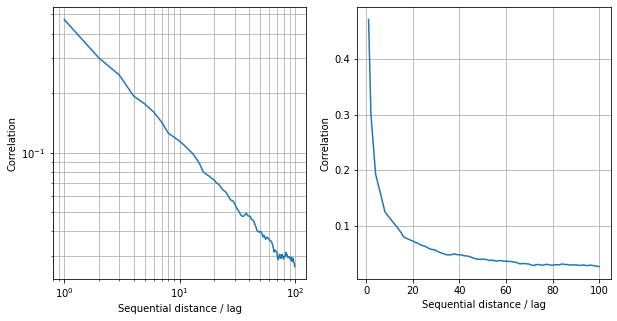

In [24]:
# plot the autocorrelation in log-log and linear
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, autocorr)
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('Correlation')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')

ax = axs[1]
ax.plot(range_, autocorr)
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('Correlation')
ax.grid(which='both')

### Now, lets look at the AutoMI

In [14]:
from automutualinformation import sequential_mutual_information as smi

In [18]:
(MI, _), (shuff_MI, _) = smi(
    [sequences], distances=range_
)

  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


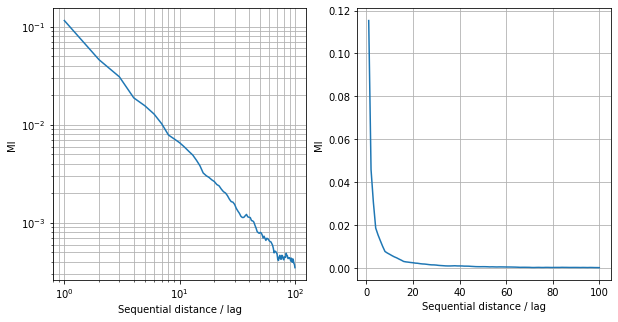

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, MI - shuff_MI)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

ax = axs[1]
ax.plot(range_, MI - shuff_MI)
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')